In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from collections import Counter

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Load the dataset
df = pd.read_csv('/kaggle/input/unlock-universal-language-with-the-lince-dataset/sa_spaeng_train.csv')

# Display the first few rows of the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (12194, 4)


,idx,words,lid,sa
0,0,"['After' 'this' 'I' ""'m"" 'just' 'gonna' 'go' '...",['lang1' 'lang1' 'lang1' 'lang1' 'lang1' 'lang...,positive
1,1,['Eating' 'a' 'good' 'as' 'posole' 'ha'],['lang1' 'lang1' 'lang1' 'lang1' 'lang2' 'ambi...,positive
2,2,"['Dale' 'mijo' ',' 'no' 'cop' 'no' 'stop']",['lang2' 'lang2' 'other' 'lang2' 'ambiguous' '...,neutral
3,3,['Damn' 'I' 'love' 'listening' 'to' 'los' 'car...,['lang1' 'lang1' 'lang1' 'lang1' 'lang1' 'lang...,positive
4,4,"['I' ""'m"" 'pretty' 'happy' 'phone' 'is' 'final...",['lang1' 'lang1' 'lang1' 'lang1' 'lang1' 'lang...,positive


Sample of df['words'] before conversion:
['[\'After\' \'this\' \'I\' "\'m" \'just\' \'gonna\' \'go\' \'home\' \'drink\' \'summ\' \'hot\'\n \'chocolate\' \'con\' \'bolillo\' \'and\' \'sleep\']', "['Eating' 'a' 'good' 'as' 'posole' 'ha']", "['Dale' 'mijo' ',' 'no' 'cop' 'no' 'stop']", "['Damn' 'I' 'love' 'listening' 'to' 'los' 'cardenales' 'de' 'nuevo' 'leon'\n 'y' 'el' 'poder' 'del' 'norte' 'at' 'night']", '[\'I\' "\'m" \'pretty\' \'happy\' \'phone\' \'is\' \'finally\' \'recognizing\' \'the\'\n \'Spanish\' \'words\' \'I\' \'use\' \'with\' \'the\' \'swipe\' \'mode\' \'on\' \'jaja\']']
Sentiment Distribution:
sa
positive    6848
neutral     3363
negative    1983
Name: count, dtype: int64


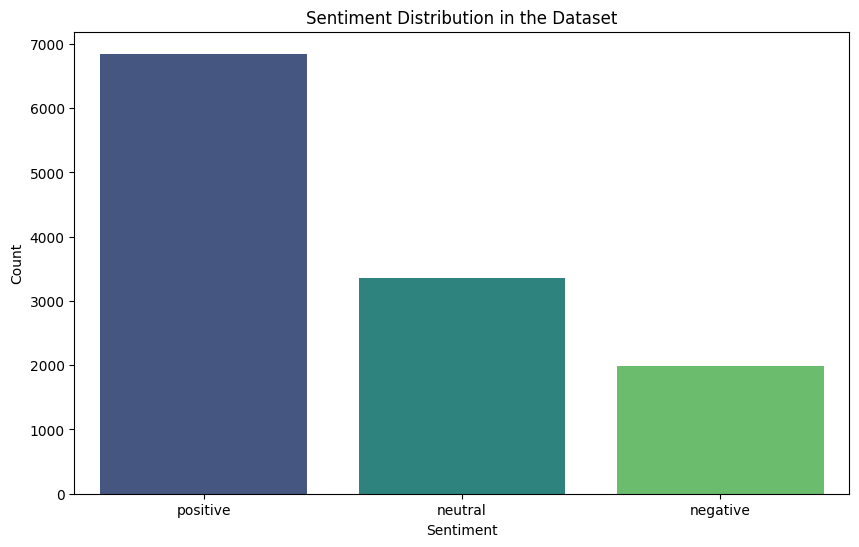


Language Distribution Statistics:
Average % of lang1 (English): 0.01%
Average % of lang2 (Spanish): 0.02%
Average % of ambiguous: 0.00%
Average % of other: 0.00%


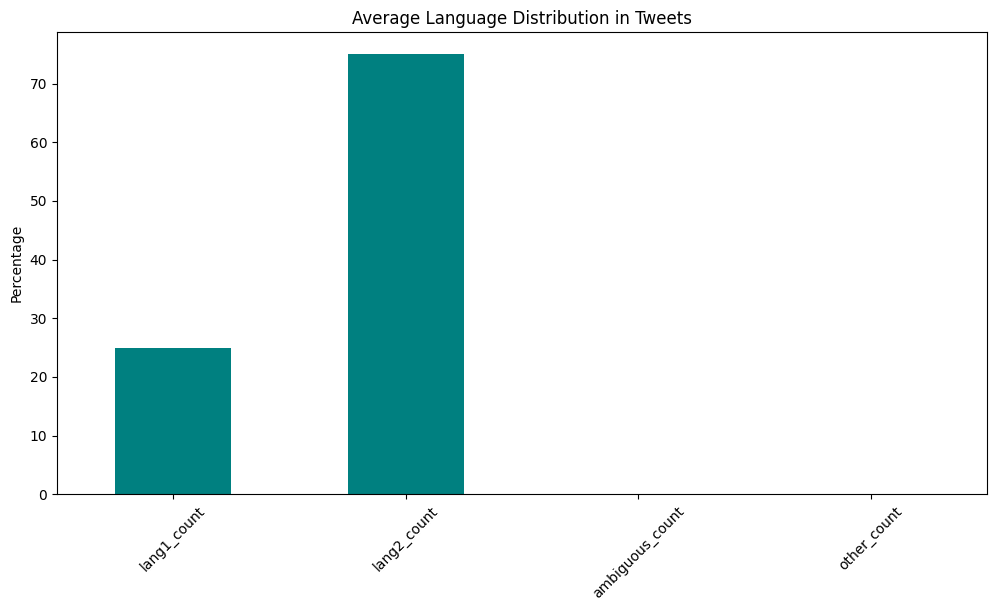

In [2]:
# First, inspect a few examples to understand the format
print("Sample of df['words'] before conversion:")
print(df['words'].head().tolist())

# Use a safer approach for conversion
def safe_eval_list(x):
    if not isinstance(x, str):
        return x
    try:
        # Try direct eval first
        return eval(x)
    except:
        try:
            # Try fixing common issues with missing commas
            fixed_str = x.replace('" "', '", "').replace('""', '" "')
            return eval(fixed_str)
        except:
            # If still failing, try a regex-based approach
            import re
            # Extract strings between quotes
            matches = re.findall(r'"([^"]*)"', x)
            if matches:
                return matches
            # If all else fails
            return x.strip('[]').split()

# Apply the safer conversion
df['words'] = df['words'].apply(safe_eval_list)
df['lid'] = df['lid'].apply(safe_eval_list)

# Check sentiment distribution
sentiment_counts = df['sa'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sa', data=df, palette='viridis')
plt.title('Sentiment Distribution in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Convert word lists to text
df['text'] = df['words'].apply(lambda x: ' '.join(x))

# Function to analyze language mixing
def analyze_language_mixing(row):
    lang_counts = Counter(row['lid'])
    return {
        'lang1_count': lang_counts.get('lang1', 0),
        'lang2_count': lang_counts.get('lang2', 0),
        'ambiguous_count': lang_counts.get('ambiguous', 0),
        'other_count': lang_counts.get('other', 0) + lang_counts.get('unk', 0) + lang_counts.get('ne', 0),
        'total_words': len(row['lid'])
    }

# Apply the function to each row
language_stats = df.apply(analyze_language_mixing, axis=1, result_type='expand')

# Display language distribution statistics
print("\nLanguage Distribution Statistics:")
print(f"Average % of lang1 (English): {(language_stats['lang1_count'] / language_stats['total_words']).mean() * 100:.2f}%")
print(f"Average % of lang2 (Spanish): {(language_stats['lang2_count'] / language_stats['total_words']).mean() * 100:.2f}%")
print(f"Average % of ambiguous: {(language_stats['ambiguous_count'] / language_stats['total_words']).mean() * 100:.2f}%")
print(f"Average % of other: {(language_stats['other_count'] / language_stats['total_words']).mean() * 100:.2f}%")

# Visualize language mixing
plt.figure(figsize=(12, 6))
language_stats_mean = language_stats.mean()
language_stats_mean = language_stats_mean[['lang1_count', 'lang2_count', 'ambiguous_count', 'other_count']]
language_stats_mean = language_stats_mean / language_stats_mean.sum() * 100
language_stats_mean.plot(kind='bar', color='teal')
plt.title('Average Language Distribution in Tweets')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sa'])

print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")

# Check if stratification worked
print("\nTraining set sentiment distribution:")
print(train_df['sa'].value_counts(normalize=True))
print("\nValidation set sentiment distribution:")
print(val_df['sa'].value_counts(normalize=True))

Training set size: 9755
Validation set size: 2439

Training set sentiment distribution:
sa
positive    0.561558
neutral     0.275756
negative    0.162686
Name: proportion, dtype: float64

Validation set sentiment distribution:
sa
positive    0.561706
neutral     0.275933
negative    0.162362
Name: proportion, dtype: float64


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Define text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
val_df['processed_text'] = val_df['text'].apply(preprocess_text)

# Create feature extraction pipelines for TF-IDF and Count Vectorizers
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))

# Train TF-IDF vectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['processed_text'])

# Train Count vectorizer
X_train_count = count_vectorizer.fit_transform(train_df['processed_text'])
X_val_count = count_vectorizer.transform(val_df['processed_text'])

# Convert sentiment labels to numerical values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sa'])
y_val = label_encoder.transform(val_df['sa'])

print(f"TF-IDF features shape: {X_train_tfidf.shape}")
print(f"Count Vector features shape: {X_train_count.shape}")
print(f"Sentiment classes: {label_encoder.classes_}")

TF-IDF features shape: (9755, 5000)
Count Vector features shape: (9755, 5000)
Sentiment classes: ['negative' 'neutral' 'positive']


In [5]:
# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)

# Predict on validation set
y_val_pred_lr_tfidf = lr_tfidf.predict(X_val_tfidf)

# Evaluate
print("Logistic Regression with TF-IDF Results:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lr_tfidf):.4f}")
print(classification_report(y_val, y_val_pred_lr_tfidf, target_names=label_encoder.classes_))

# Logistic Regression with Count Vectors
lr_count = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
lr_count.fit(X_train_count, y_train)

# Predict on validation set
y_val_pred_lr_count = lr_count.predict(X_val_count)

# Evaluate
print("\nLogistic Regression with Count Vectors Results:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_lr_count):.4f}")
print(classification_report(y_val, y_val_pred_lr_count, target_names=label_encoder.classes_))

# Record model performance for comparison
model_performance = {
    'Logistic Regression (TF-IDF)': {
        'accuracy': accuracy_score(y_val, y_val_pred_lr_tfidf),
        'inference_time': 'Fast (CPU sufficient)'
    },
    'Logistic Regression (Count)': {
        'accuracy': accuracy_score(y_val, y_val_pred_lr_count),
        'inference_time': 'Fast (CPU sufficient)'
    }
}

Logistic Regression with TF-IDF Results:
Accuracy: 0.5625
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.67      0.00      0.01       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.41      0.33      0.24      2439
weighted avg       0.50      0.56      0.41      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Logistic Regression with Count Vectors Results:
Accuracy: 0.5625
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.67      0.00      0.01       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.41      0.33      0.24      2439
weighted avg       0.50      0.56      0.41      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Predict on validation set
y_val_pred_nb_tfidf = nb_tfidf.predict(X_val_tfidf)

# Evaluate
print("Naive Bayes with TF-IDF Results:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_nb_tfidf):.4f}")
print(classification_report(y_val, y_val_pred_nb_tfidf, target_names=label_encoder.classes_))

# Naive Bayes with Count Vectors
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)

# Predict on validation set
y_val_pred_nb_count = nb_count.predict(X_val_count)

# Evaluate
print("\nNaive Bayes with Count Vectors Results:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_nb_count):.4f}")
print(classification_report(y_val, y_val_pred_nb_count, target_names=label_encoder.classes_))

# Update model performance for comparison
model_performance.update({
    'Naive Bayes (TF-IDF)': {
        'accuracy': accuracy_score(y_val, y_val_pred_nb_tfidf),
        'inference_time': 'Very Fast (CPU sufficient)'
    },
    'Naive Bayes (Count)': {
        'accuracy': accuracy_score(y_val, y_val_pred_nb_count),
        'inference_time': 'Very Fast (CPU sufficient)'
    }
})

Naive Bayes with TF-IDF Results:
Accuracy: 0.5625
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.67      0.00      0.01       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.41      0.33      0.24      2439
weighted avg       0.50      0.56      0.41      2439


Naive Bayes with Count Vectors Results:
Accuracy: 0.5625
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.67      0.00      0.01       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.41      0.33      0.24      2439
weighted avg       0.50      0.56      0.41      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import time

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a custom dataset class
class TextSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize label encoder if not already done
if 'label_encoder' not in locals():
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['sa'])
    y_val = label_encoder.transform(val_df['sa'])

print(f"Unique sentiment labels: {label_encoder.classes_}")

Using device: cuda
Unique sentiment labels: ['negative' 'neutral' 'positive']


In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# Define LSTM Model
class LSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout, 
                           batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [batch size, seq len]
        embedded = self.dropout(self.embedding(text))
        
        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Unpack sequence
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
            
        return self.fc(hidden)

# --------- REPLACE FROM HERE ---------

# Simple tokenizer function
def simple_tokenizer(text):
    # Basic tokenization by splitting on spaces and removing punctuation
    import re
    return re.findall(r'\w+', text.lower())

# Instead of torchtext's vocab builder, create a simple vocabulary
def build_simple_vocab(text_iterator):
    vocab = {'<unk>': 0, '<pad>': 1}
    idx = 2
    for text in text_iterator:
        for token in simple_tokenizer(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

# Build vocabulary from training data
tokenizer = simple_tokenizer
vocab = build_simple_vocab(train_df['processed_text'])

# Text to tensor converter
def text_pipeline(text):
    return [vocab.get(token, vocab['<unk>']) for token in tokenizer(text)]

# --------- TO HERE ---------

# Create data loader function for LSTM
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for text, label in batch:
        label_list.append(label)
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.long)
        text_list.append(processed_text)
        lengths.append(len(processed_text))
    
    labels = torch.tensor(label_list, dtype=torch.long)
    padded_texts = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])
    lengths = torch.tensor(lengths)
    
    return padded_texts, labels, lengths

# Create PyTorch datasets and dataloaders
from torch.utils.data import DataLoader, Dataset
class SimpleDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets
train_dataset = SimpleDataset(train_df['processed_text'].tolist(), y_train)
val_dataset = SimpleDataset(val_df['processed_text'].tolist(), y_val)

# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

print(f"Vocabulary size: {len(vocab)}")
print(f"Number of batches in training: {len(train_dataloader)}")
print(f"Number of batches in validation: {len(val_dataloader)}")

Vocabulary size: 9722
Number of batches in training: 610
Number of batches in validation: 153


Starting LSTM model training (this may take some time, GPU is recommended)...
Epoch: 01 | Epoch Time: 0.0m 4.67s
	Train Loss: 0.993 | Train Acc: 56.00%
	Val. Loss: 0.979 | Val. Acc: 56.17%
Epoch: 02 | Epoch Time: 0.0m 3.87s
	Train Loss: 0.975 | Train Acc: 55.91%
	Val. Loss: 0.983 | Val. Acc: 56.17%
Epoch: 03 | Epoch Time: 0.0m 4.11s
	Train Loss: 0.953 | Train Acc: 56.29%
	Val. Loss: 0.974 | Val. Acc: 56.21%


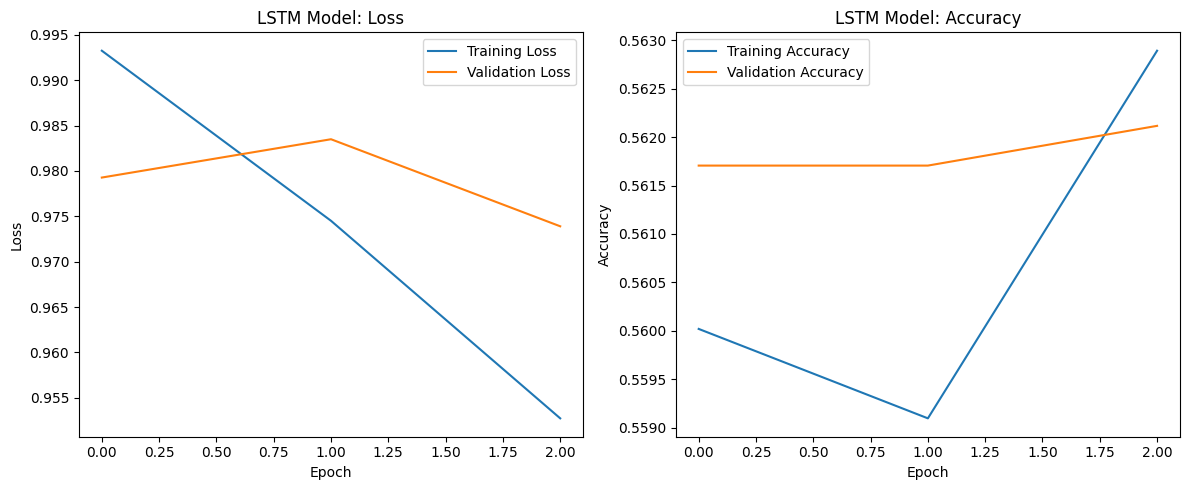

LSTM Model Results:
Accuracy: 0.5621
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.33      0.00      0.00       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.30      0.33      0.24      2439
weighted avg       0.41      0.56      0.41      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=5):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        
        for texts, labels, lengths in train_dataloader:
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            optimizer.zero_grad()
            
            predictions = model(texts, lengths)
            
            loss = criterion(predictions, labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            predictions = torch.argmax(predictions, dim=1)
            correct = (predictions == labels).float().sum()
            epoch_acc += correct.item()
        
        # Calculate average training loss and accuracy
        train_loss = epoch_loss / len(train_dataloader)
        train_acc = epoch_acc / len(train_dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for texts, labels, lengths in val_dataloader:
                texts = texts.to(device)
                labels = labels.to(device)
                lengths = lengths.to(device)
                
                predictions = model(texts, lengths)
                
                loss = criterion(predictions, labels)
                
                val_loss += loss.item()
                
                predictions = torch.argmax(predictions, dim=1)
                correct = (predictions == labels).float().sum()
                val_acc += correct.item()
        
        # Calculate average validation loss and accuracy
        val_loss = val_loss / len(val_dataloader)
        val_acc = val_acc / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'lstm_sentiment_model.pt')
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}%')
    
    return train_losses, val_losses, train_accs, val_accs

# Initialize model
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_encoder.classes_)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab['<pad>']

lstm_model = LSTMSentimentModel(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    HIDDEN_DIM, 
    OUTPUT_DIM, 
    N_LAYERS, 
    BIDIRECTIONAL, 
    DROPOUT, 
    PAD_IDX
).to(device)

# Initialize optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

# Train the model (Note: This might take some time, especially on CPU)
# GPU is recommended but not essential
print("Starting LSTM model training (this may take some time, GPU is recommended)...")
train_losses, val_losses, train_accs, val_accs = train_model(
    lstm_model, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    criterion, 
    device, 
    epochs=3  # Reduced from typical 5-10 epochs for demonstration
)

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('LSTM Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('LSTM Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate LSTM model on validation set
lstm_model.eval()
y_val_pred_lstm = []
y_val_true = []

with torch.no_grad():
    for texts, labels, lengths in val_dataloader:
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        predictions = lstm_model(texts, lengths)
        predictions = torch.argmax(predictions, dim=1).cpu().numpy()
        
        y_val_pred_lstm.extend(predictions)
        y_val_true.extend(labels.cpu().numpy())

# Print LSTM evaluation
print("LSTM Model Results:")
print(f"Accuracy: {accuracy_score(y_val_true, y_val_pred_lstm):.4f}")
print(classification_report(y_val_true, y_val_pred_lstm, target_names=label_encoder.classes_))

# Update model performance for comparison
model_performance.update({
    'LSTM': {
        'accuracy': accuracy_score(y_val_true, y_val_pred_lstm),
        'inference_time': 'Moderate (GPU recommended)'
    }
})

Starting Bi-LSTM model training (this may take some time, GPU is recommended)...
Epoch: 01 | Epoch Time: 0.0m 3.74s
	Train Loss: 0.993 | Train Acc: 55.90%
	Val. Loss: 0.976 | Val. Acc: 56.17%
Epoch: 02 | Epoch Time: 0.0m 3.78s
	Train Loss: 0.974 | Train Acc: 55.94%
	Val. Loss: 0.980 | Val. Acc: 56.17%
Epoch: 03 | Epoch Time: 0.0m 3.74s
	Train Loss: 0.954 | Train Acc: 56.20%
	Val. Loss: 1.046 | Val. Acc: 56.17%


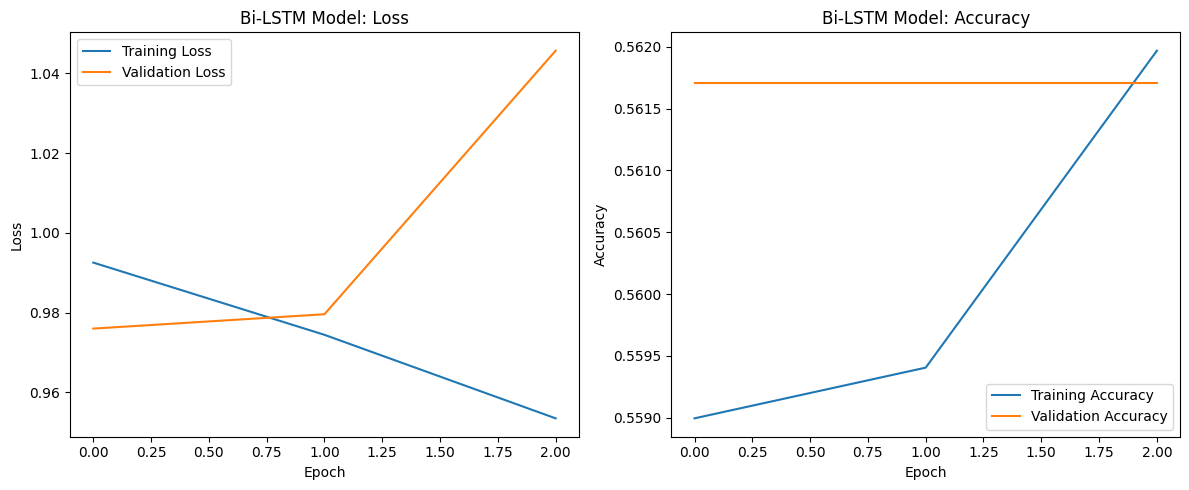

Bi-LSTM Model Results:
Accuracy: 0.5617
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.00      0.00      0.00       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.19      0.33      0.24      2439
weighted avg       0.32      0.56      0.40      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Define Bi-LSTM Model (note: we already defined a bidirectional LSTM earlier, but let's make a specific version)
class BiLSTMSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout, 
                           batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [batch size, seq len]
        embedded = self.dropout(self.embedding(text))
        
        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # Get the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
            
        return self.fc(hidden)

# Initialize Bi-LSTM model
bi_lstm_model = BiLSTMSentimentModel(
    INPUT_DIM, 
    EMBEDDING_DIM, 
    HIDDEN_DIM, 
    OUTPUT_DIM, 
    N_LAYERS, 
    DROPOUT, 
    PAD_IDX
).to(device)

# Initialize optimizer and loss function
optimizer = optim.Adam(bi_lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

# Train the model
print("Starting Bi-LSTM model training (this may take some time, GPU is recommended)...")
train_losses, val_losses, train_accs, val_accs = train_model(
    bi_lstm_model, 
    train_dataloader, 
    val_dataloader, 
    optimizer, 
    criterion, 
    device, 
    epochs=3  # Reduced for demonstration
)

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Bi-LSTM Model: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Bi-LSTM Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate Bi-LSTM model on validation set
bi_lstm_model.eval()
y_val_pred_bilstm = []
y_val_true = []

with torch.no_grad():
    for texts, labels, lengths in val_dataloader:
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        predictions = bi_lstm_model(texts, lengths)
        predictions = torch.argmax(predictions, dim=1).cpu().numpy()
        
        y_val_pred_bilstm.extend(predictions)
        y_val_true.extend(labels.cpu().numpy())

# Print Bi-LSTM evaluation
print("Bi-LSTM Model Results:")
print(f"Accuracy: {accuracy_score(y_val_true, y_val_pred_bilstm):.4f}")
print(classification_report(y_val_true, y_val_pred_bilstm, target_names=label_encoder.classes_))

# Update model performance for comparison
model_performance.update({
    'Bi-LSTM': {
        'accuracy': accuracy_score(y_val_true, y_val_pred_bilstm),
        'inference_time': 'Moderate (GPU recommended)'
    }
})

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load pretrained multilingual tokenizer and model
model_name = "bert-base-multilingual-cased"  # mBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert pandas DataFrames to Hugging Face datasets
def convert_to_hf_dataset(df, tokenizer, max_length=128):
    df = df.copy()
    
    # Create Hugging Face dataset
    dataset = Dataset.from_pandas(df[['text', 'sa']])
    
    # Tokenize function
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
    
    # Tokenize the datasets
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    
    # Rename 'sa' column to 'label' and encode labels
    tokenized_dataset = tokenized_dataset.map(
        lambda example: {'label': label_encoder.transform([example['sa']])[0]},
        remove_columns=['sa']
    )
    
    return tokenized_dataset

# Create tokenized datasets
tokenized_train_dataset = convert_to_hf_dataset(train_df, tokenizer)
tokenized_val_dataset = convert_to_hf_dataset(val_df, tokenizer)

print(f"Tokenized train dataset: {tokenized_train_dataset}")
print(f"Tokenized validation dataset: {tokenized_val_dataset}")

# Load pretrained model
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir=f'./results/{model_name}',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # Reduced for demonstration
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir=f'./logs/{model_name}',
    logging_steps=10,
    report_to="none"
)

# Initialize Trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting mBERT model training (this will take time, GPU is essential)...")
# Train the model and evaluate
train_results = trainer.train()
trainer.save_model("./mbert_sentiment_model")

# Evaluate the model
eval_results = trainer.evaluate()
print(f"mBERT Evaluation results: {eval_results}")

# Make predictions on validation set
pred_output = trainer.predict(tokenized_val_dataset)
y_val_pred_mbert = pred_output.predictions.argmax(-1)
y_val_true_mbert = pred_output.label_ids

# Print mBERT evaluation
print("mBERT Model Results:")
print(f"Accuracy: {accuracy_score(y_val_true_mbert, y_val_pred_mbert):.4f}")

2025-05-03 15:55:06.319251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746287706.518206      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746287706.572335      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/9755 [00:00<?, ? examples/s]

Map:   0%|          | 0/9755 [00:00<?, ? examples/s]

Map:   0%|          | 0/2439 [00:00<?, ? examples/s]

Map:   0%|          | 0/2439 [00:00<?, ? examples/s]

Tokenized train dataset: Dataset({
    features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 9755
})
Tokenized validation dataset: Dataset({
    features: ['text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 2439
})


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/959322418.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting mBERT model training (this will take time, GPU is essential)...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.124100
20,1.102700
30,1.092200
40,1.058200
50,1.023400
60,1.031500
70,0.944100
80,0.954400
90,0.990200
100,0.937200


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


mBERT Evaluation results: {'eval_loss': 0.9318203926086426, 'eval_accuracy': 0.5563755637556376, 'eval_f1': 0.46703995956564115, 'eval_precision': 0.473626343413688, 'eval_recall': 0.5563755637556376, 'eval_runtime': 17.7659, 'eval_samples_per_second': 137.286, 'eval_steps_per_second': 8.612, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


mBERT Model Results:
Accuracy: 0.5564


In [12]:
# Complete mBERT evaluation
print("mBERT Model Results:")
print(f"Accuracy: {accuracy_score(y_val_true_mbert, y_val_pred_mbert):.4f}")
print(classification_report(y_val_true_mbert, y_val_pred_mbert, target_names=label_encoder.classes_))

# Update model performance for comparison
model_performance.update({
    'mBERT': {
        'accuracy': accuracy_score(y_val_true_mbert, y_val_pred_mbert),
        'inference_time': 'Slow (GPU essential)'
    }
})

mBERT Model Results:
Accuracy: 0.5564
              precision    recall  f1-score   support

    negative       0.35      0.22      0.27       396
     neutral       0.31      0.04      0.08       673
    positive       0.59      0.91      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.42      0.39      0.35      2439
weighted avg       0.47      0.56      0.47      2439



In [13]:
# Load XLM-RoBERTa - A more powerful multilingual model
xlm_model_name = "xlm-roberta-base"
xlm_tokenizer = AutoTokenizer.from_pretrained(xlm_model_name)

# Create tokenized datasets for XLM-RoBERTa
xlm_tokenized_train_dataset = convert_to_hf_dataset(train_df, xlm_tokenizer)
xlm_tokenized_val_dataset = convert_to_hf_dataset(val_df, xlm_tokenizer)

# Load pretrained model
xlm_model = AutoModelForSequenceClassification.from_pretrained(
    xlm_model_name, 
    num_labels=num_labels
)

# Initialize Trainer
xlm_data_collator = DataCollatorWithPadding(tokenizer=xlm_tokenizer)
xlm_trainer = Trainer(
    model=xlm_model,
    args=training_args,
    train_dataset=xlm_tokenized_train_dataset,
    eval_dataset=xlm_tokenized_val_dataset,
    tokenizer=xlm_tokenizer,
    data_collator=xlm_data_collator,
    compute_metrics=compute_metrics,
)

print("Starting XLM-RoBERTa model training (this will take time, GPU is essential)...")
# Train the model and evaluate
xlm_train_results = xlm_trainer.train()
xlm_trainer.save_model("./xlm_roberta_sentiment_model")

# Evaluate the model
xlm_eval_results = xlm_trainer.evaluate()
print(f"XLM-RoBERTa Evaluation results: {xlm_eval_results}")

# Make predictions on validation set
xlm_pred_output = xlm_trainer.predict(xlm_tokenized_val_dataset)
y_val_pred_xlm = xlm_pred_output.predictions.argmax(-1)
y_val_true_xlm = xlm_pred_output.label_ids

# Print XLM-RoBERTa evaluation
print("XLM-RoBERTa Model Results:")
print(f"Accuracy: {accuracy_score(y_val_true_xlm, y_val_pred_xlm):.4f}")
print(classification_report(y_val_true_xlm, y_val_pred_xlm, target_names=label_encoder.classes_))

# Update model performance for comparison
model_performance.update({
    'XLM-RoBERTa': {
        'accuracy': accuracy_score(y_val_true_xlm, y_val_pred_xlm),
        'inference_time': 'Slow (GPU essential)'
    }
})

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/9755 [00:00<?, ? examples/s]

Map:   0%|          | 0/9755 [00:00<?, ? examples/s]

Map:   0%|          | 0/2439 [00:00<?, ? examples/s]

Map:   0%|          | 0/2439 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/363354442.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  xlm_trainer = Trainer(


Starting XLM-RoBERTa model training (this will take time, GPU is essential)...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.093200
20,1.080100
30,1.071200
40,1.087900
50,1.055900
60,1.078100
70,1.031300
80,1.024700
90,1.035800
100,0.979400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


XLM-RoBERTa Evaluation results: {'eval_loss': 0.928367018699646, 'eval_accuracy': 0.5617056170561706, 'eval_f1': 0.4040623236371509, 'eval_precision': 0.31551320023245333, 'eval_recall': 0.5617056170561706, 'eval_runtime': 22.721, 'eval_samples_per_second': 107.346, 'eval_steps_per_second': 6.734, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XLM-RoBERTa Model Results:
Accuracy: 0.5617
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.00      0.00      0.00       673
    positive       0.56      1.00      0.72      1370

    accuracy                           0.56      2439
   macro avg       0.19      0.33      0.24      2439
weighted avg       0.32      0.56      0.40      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Performance Comparison:
                          Model accuracy              inference_time
0  Logistic Regression (TF-IDF)   0.5625       Fast (CPU sufficient)
1   Logistic Regression (Count)   0.5625       Fast (CPU sufficient)
2          Naive Bayes (TF-IDF)   0.5625  Very Fast (CPU sufficient)
3           Naive Bayes (Count)   0.5625  Very Fast (CPU sufficient)
4                          LSTM   0.5621  Moderate (GPU recommended)
5                       Bi-LSTM   0.5617  Moderate (GPU recommended)
7                   XLM-RoBERTa   0.5617        Slow (GPU essential)
6                         mBERT   0.5564        Slow (GPU essential)


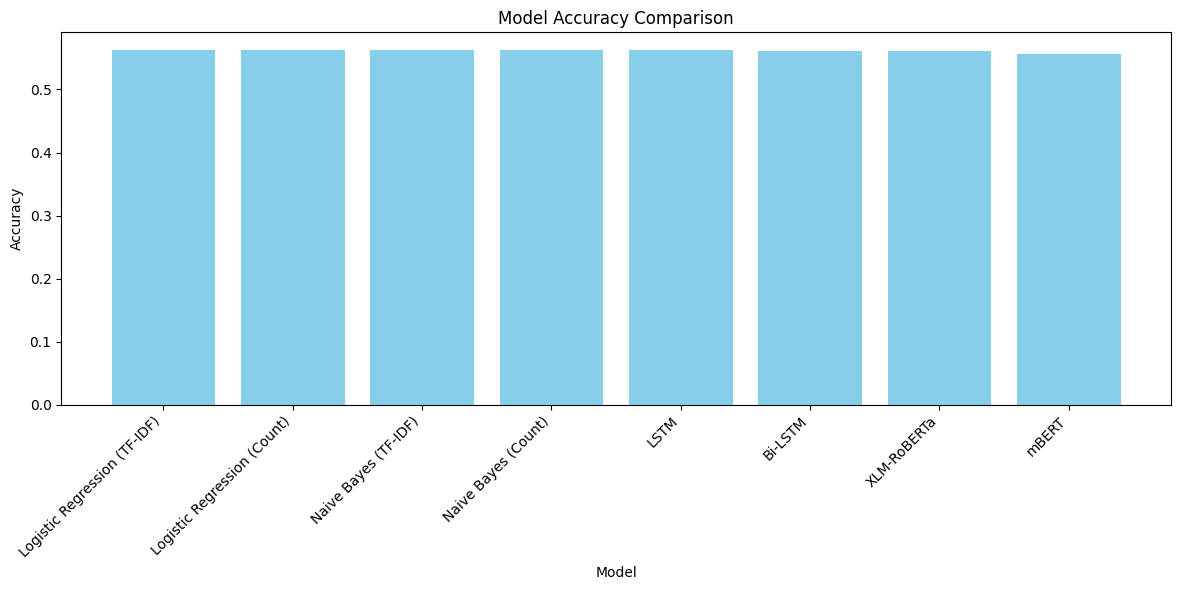

Logistic Regression (TF-IDF):
  - Accuracy: 0.5625
  - Inference Time: Fast (CPU sufficient)
Logistic Regression (Count):
  - Accuracy: 0.5625
  - Inference Time: Fast (CPU sufficient)
Naive Bayes (TF-IDF):
  - Accuracy: 0.5625
  - Inference Time: Very Fast (CPU sufficient)
Naive Bayes (Count):
  - Accuracy: 0.5625
  - Inference Time: Very Fast (CPU sufficient)
LSTM:
  - Accuracy: 0.5621
  - Inference Time: Moderate (GPU recommended)
Bi-LSTM:
  - Accuracy: 0.5617
  - Inference Time: Moderate (GPU recommended)
mBERT:
  - Accuracy: 0.5564
  - Inference Time: Slow (GPU essential)
XLM-RoBERTa:
  - Accuracy: 0.5617
  - Inference Time: Slow (GPU essential)


In [14]:
# Convert model performance to DataFrame for comparison
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
performance_df = performance_df.reset_index().rename(columns={'index': 'Model'})
performance_df['accuracy'] = performance_df['accuracy'].apply(lambda x: f"{x:.4f}")

# Sort by accuracy (descending)
performance_df = performance_df.sort_values('accuracy', ascending=False)

# Display comparison table
print("Model Performance Comparison:")
print(performance_df)

# Visualize model accuracy
plt.figure(figsize=(12, 6))
plt.bar(
    performance_df['Model'], 
    performance_df['accuracy'].astype(float), 
    color='skyblue'
)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Add inference time information
for model_name, info in model_performance.items():
    print(f"{model_name}:")
    print(f"  - Accuracy: {info['accuracy']:.4f}")
    print(f"  - Inference Time: {info['inference_time']}")

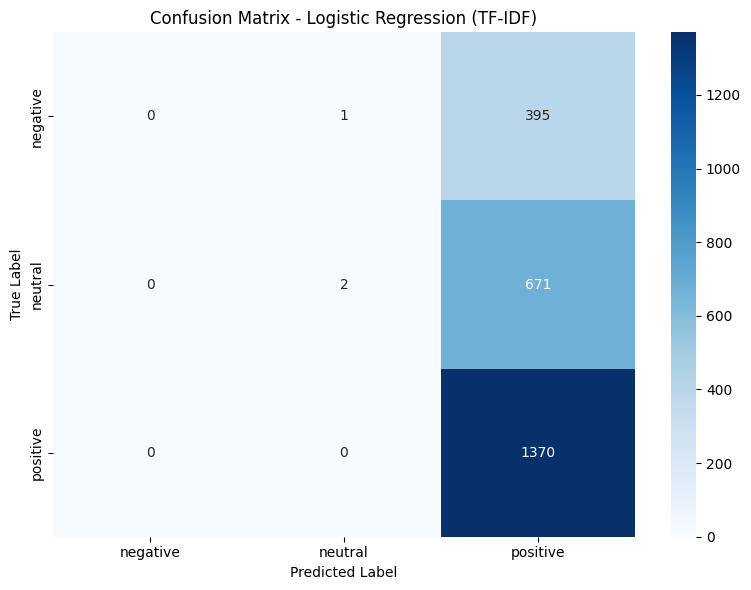

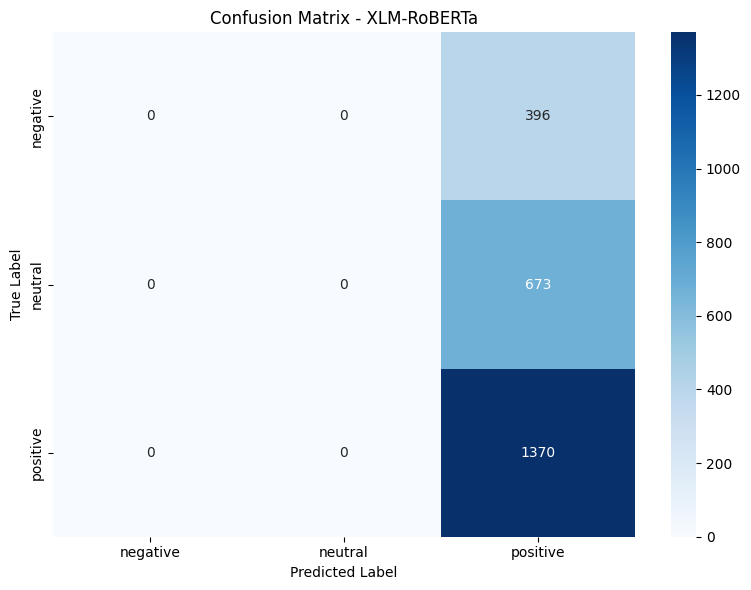

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Get the best classical ML model
best_classical_acc = max(
    accuracy_score(y_val, y_val_pred_lr_tfidf),
    accuracy_score(y_val, y_val_pred_lr_count),
    accuracy_score(y_val, y_val_pred_nb_tfidf),
    accuracy_score(y_val, y_val_pred_nb_count)
)

if best_classical_acc == accuracy_score(y_val, y_val_pred_lr_tfidf):
    best_classical_name = "Logistic Regression (TF-IDF)"
    best_classical_preds = y_val_pred_lr_tfidf
elif best_classical_acc == accuracy_score(y_val, y_val_pred_lr_count):
    best_classical_name = "Logistic Regression (Count)"
    best_classical_preds = y_val_pred_lr_count
elif best_classical_acc == accuracy_score(y_val, y_val_pred_nb_tfidf):
    best_classical_name = "Naive Bayes (TF-IDF)"
    best_classical_preds = y_val_pred_nb_tfidf
else:
    best_classical_name = "Naive Bayes (Count)"
    best_classical_preds = y_val_pred_nb_count

# Get the best neural model
best_neural_acc = max(
    accuracy_score(y_val_true_mbert, y_val_pred_mbert),
    accuracy_score(y_val_true_xlm, y_val_pred_xlm),
    accuracy_score(y_val_true, y_val_pred_bilstm)
)

if best_neural_acc == accuracy_score(y_val_true_mbert, y_val_pred_mbert):
    best_neural_name = "mBERT"
    best_neural_preds = y_val_pred_mbert
    best_neural_true = y_val_true_mbert
elif best_neural_acc == accuracy_score(y_val_true_xlm, y_val_pred_xlm):
    best_neural_name = "XLM-RoBERTa"
    best_neural_preds = y_val_pred_xlm
    best_neural_true = y_val_true_xlm
else:
    best_neural_name = "Bi-LSTM"
    best_neural_preds = y_val_pred_bilstm
    best_neural_true = y_val_true

# Plot confusion matrices for best models
plot_confusion_matrix(y_val, best_classical_preds, label_encoder.classes_, f"Confusion Matrix - {best_classical_name}")
plot_confusion_matrix(best_neural_true, best_neural_preds, label_encoder.classes_, f"Confusion Matrix - {best_neural_name}")

In [16]:
# Function to find examples of errors
def analyze_errors(texts, true_labels, pred_labels, class_names):
    errors = {}
    for true_class in range(len(class_names)):
        for pred_class in range(len(class_names)):
            if true_class != pred_class:
                # Find examples where true_class was misclassified as pred_class
                indices = [i for i, (true, pred) in enumerate(zip(true_labels, pred_labels)) 
                           if true == true_class and pred == pred_class]
                
                if indices:
                    key = f"{class_names[true_class]} misclassified as {class_names[pred_class]}"
                    errors[key] = [texts[i] for i in indices[:3]]  # Get up to 3 examples
    
    return errors

# Analyze errors in the best neural model
best_model_errors = analyze_errors(
    val_df['text'].values, 
    best_neural_true, 
    best_neural_preds, 
    label_encoder.classes_
)

# Print error examples
print(f"Error analysis for {best_neural_name}:")
for error_type, examples in best_model_errors.items():
    print(f"\n{error_type}:")
    for i, example in enumerate(examples):
        print(f"  {i+1}. {example}")

Error analysis for XLM-RoBERTa:

negative misclassified as positive:
  1. MadremíaKronnoperoquehacesdespiertoaestashoras?,noparecesniYoutuber!AjajajBuenosdíasZombers!
  2. Alloverthenews:Entodaslasnoticias.Person1:DidyoufindoutaboutJenniRivera’sdeath?Person2:Yes,it’salloverthenews!
  3. Cuzsthenitzayanamevaakitarlokemedieron-.-

neutral misclassified as positive:
  1. ¿Vacacionessinmúsica?Nah.TráelaJBLFLIP3Speakeradondesea.Consigueloaquí:https://t.co/5QherKvlrRhttps://t.co/Hu02Lk8jbB
  2. Lasoreothinssabenmejorquelasoriginales
  3. Osrecuerdoquepodeisvotarnos5vecesaldiacontansoloponerloshastag!^^yanoosmolestomas!😋😋😜Sorry!


In [17]:
def lstm_tokenizer(text):
    return preprocess_text(text).split()  # or use the one you used during training

# Create a function to predict sentiment of new text
def predict_sentiment(text, model_type='transformer'):
    """
    Predict sentiment of new text using the specified model type.
    
    Args:
        text (str): Input text for sentiment analysis
        model_type (str): Type of model to use ('classical', 'lstm', or 'transformer')
        
    Returns:
        str: Predicted sentiment (positive, negative, neutral)
    """
    if model_type == 'classical':
        # Preprocess the text
        processed_text = preprocess_text(text)
        
        # Transform using TF-IDF
        text_features = tfidf_vectorizer.transform([processed_text])
        
        # Predict using best classical model (assuming Logistic Regression with TF-IDF)
        prediction = lr_tfidf.predict(text_features)[0]
        
    elif model_type == 'lstm':
        # Preprocess and tokenize using LSTM-friendly tokenizer
        processed_text = preprocess_text(text)
        tokens = lstm_tokenizer(processed_text)
        UNK_IDX = vocab.get('<unk>', 0)
        text_tensor = torch.tensor([vocab.get(token, UNK_IDX) for token in tokens], dtype=torch.long).unsqueeze(0).to(device)
        length_tensor = torch.tensor([len(tokens)]).to(device)
    
        # Set model to eval mode
        bi_lstm_model.eval()
        
        with torch.no_grad():
            prediction = torch.argmax(bi_lstm_model(text_tensor, length_tensor), dim=1).item()

            
    elif model_type == 'transformer':
        # Tokenize the text
        inputs = xlm_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Set model to evaluation mode
        xlm_model.eval()
        
        # Get prediction
        with torch.no_grad():
            outputs = xlm_model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Return the sentiment label
    return label_encoder.classes_[prediction]

# Test the prediction function with some examples
test_texts = [
    "I love how this mixes Spanish and English, it's amazing!",
    "No me gusta nada this terrible service",
    "It's okay pero podría ser mejor",
    "Acabo de terminar! El rap del Tag del Youtuber! Que fucking cansancio!"
]

print("Sentiment Predictions:")
for i, text in enumerate(test_texts):
    classical_pred = predict_sentiment(text, 'classical')
    lstm_pred = predict_sentiment(text, 'lstm')
    transformer_pred = predict_sentiment(text, 'transformer')
    
    print(f"\nText {i+1}: {text}")
    print(f"  Classical Model: {classical_pred}")
    print(f"  Bi-LSTM Model: {lstm_pred}")
    print(f"  Transformer Model: {transformer_pred}")

Sentiment Predictions:

Text 1: I love how this mixes Spanish and English, it's amazing!
  Classical Model: positive
  Bi-LSTM Model: positive
  Transformer Model: positive

Text 2: No me gusta nada this terrible service
  Classical Model: positive
  Bi-LSTM Model: positive
  Transformer Model: positive

Text 3: It's okay pero podría ser mejor
  Classical Model: positive
  Bi-LSTM Model: positive
  Transformer Model: positive

Text 4: Acabo de terminar! El rap del Tag del Youtuber! Que fucking cansancio!
  Classical Model: positive
  Bi-LSTM Model: positive
  Transformer Model: positive


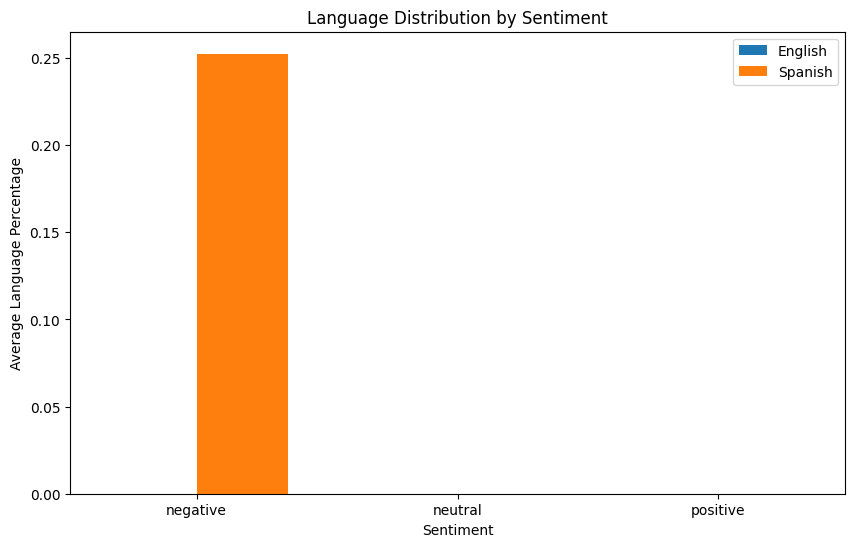


Model accuracy by English percentage:
  (0, 25]: nan
  (25, 50]: nan
  (50, 75]: nan
  (75, 100]: nan


/tmp/ipykernel_31/1313763608.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_by_lang = val_df.groupby(lang_bins)['best_model_correct'].mean()


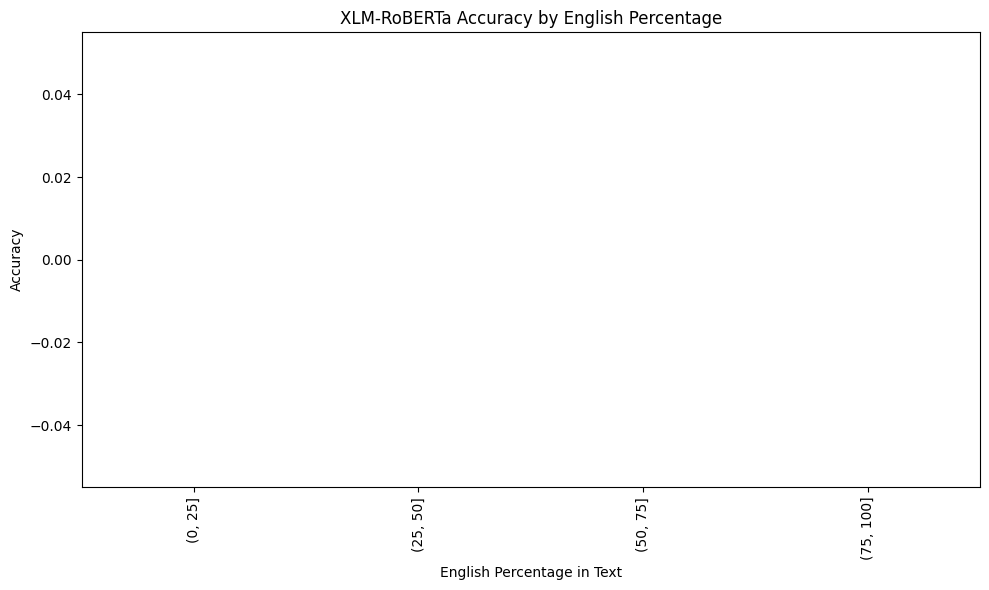

In [18]:
# Analyze how language mixing affects sentiment classification
def calculate_language_ratio(row):
    lang_counts = Counter(row['lid'])
    total_words = len(row['lid'])
    
    # Calculate language percentages
    lang1_percent = lang_counts.get('lang1', 0) / total_words * 100  # English
    lang2_percent = lang_counts.get('lang2', 0) / total_words * 100  # Spanish
    
    return lang1_percent, lang2_percent

# Calculate language percentages for each text
val_df['lang1_percent'], val_df['lang2_percent'] = zip(*val_df.apply(calculate_language_ratio, axis=1))

# Group by sentiment and get average language percentages
sentiment_lang_stats = val_df.groupby('sa').agg({
    'lang1_percent': 'mean',
    'lang2_percent': 'mean'
}).reset_index()

# Visualize language distribution by sentiment
plt.figure(figsize=(10, 6))
x = np.arange(len(sentiment_lang_stats['sa']))
width = 0.35

plt.bar(x - width/2, sentiment_lang_stats['lang1_percent'], width, label='English')
plt.bar(x + width/2, sentiment_lang_stats['lang2_percent'], width, label='Spanish')

plt.ylabel('Average Language Percentage')
plt.xlabel('Sentiment')
plt.title('Language Distribution by Sentiment')
plt.xticks(x, sentiment_lang_stats['sa'])
plt.legend()
plt.show()

# Analyze model performance by language ratio
val_df['best_model_correct'] = best_neural_preds == best_neural_true

# Group by language dominance and check accuracy
lang_bins = pd.cut(val_df['lang1_percent'], bins=[0, 25, 50, 75, 100])
performance_by_lang = val_df.groupby(lang_bins)['best_model_correct'].mean()

print("\nModel accuracy by English percentage:")
for bin_range, accuracy in performance_by_lang.items():
    print(f"  {bin_range}: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
performance_by_lang.plot(kind='bar')
plt.title(f'{best_neural_name} Accuracy by English Percentage')
plt.xlabel('English Percentage in Text')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [19]:
# Create a comprehensive model wrapper for deployment
class MultilingualSentimentAnalyzer:
    def __init__(self, model_type='transformer'):
        self.model_type = model_type
        self.label_encoder = label_encoder
        
        if model_type == 'classical':
            self.tfidf_vectorizer = tfidf_vectorizer
            self.model = lr_tfidf
            print("Loaded Logistic Regression with TF-IDF model")
            
        elif model_type == 'lstm':
            self.tokenizer = tokenizer
            self.vocab = vocab
            self.model = bi_lstm_model
            self.device = device
            print("Loaded Bi-LSTM model")
            
        elif model_type == 'transformer':
            self.tokenizer = xlm_tokenizer
            self.model = xlm_model
            self.device = device
            print("Loaded XLM-RoBERTa model")
    
    def preprocess(self, text):
        if self.model_type == 'classical':
            return preprocess_text(text)
        return text
    
    def predict(self, text):
        processed_text = self.preprocess(text)
        
        if self.model_type == 'classical':
            features = self.tfidf_vectorizer.transform([processed_text])
            prediction = self.model.predict(features)[0]
            confidence = np.max(self.model.predict_proba(features)[0])
            
        elif self.model_type == 'lstm':
            # Tokenize
            tokens = self.tokenizer(processed_text)
            text_tensor = torch.tensor([self.vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(self.device)
            length_tensor = torch.tensor([len(tokens)]).to(self.device)
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Get prediction
            with torch.no_grad():
                outputs = self.model(text_tensor, length_tensor)
                probabilities = F.softmax(outputs, dim=1)
                prediction = torch.argmax(probabilities, dim=1).item()
                confidence = torch.max(probabilities).item()
                
        elif self.model_type == 'transformer':
            # Tokenize
            inputs = self.tokenizer(processed_text, return_tensors='pt', truncation=True, padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Get prediction
            with torch.no_grad():
                outputs = self.model(**inputs)
                probabilities = F.softmax(outputs.logits, dim=1)
                prediction = torch.argmax(probabilities, dim=1).item()
                confidence = torch.max(probabilities).item()
        
        # Return sentiment label and confidence
        return {
            'sentiment': self.label_encoder.classes_[prediction],
            'confidence': float(confidence),
            'model_type': self.model_type
        }

# Initialize analyzers
classical_analyzer = MultilingualSentimentAnalyzer('classical')
transformer_analyzer = MultilingualSentimentAnalyzer('transformer')

# Create a function to demonstrate the analyzer
def analyze_user_input(text):
    print(f"\nText: {text}")
    
    # Get predictions
    classical_result = classical_analyzer.predict(text)
    transformer_result = transformer_analyzer.predict(text)
    
    # Display results
    print("\nClassical Model Result:")
    print(f"  Sentiment: {classical_result['sentiment']}")
    print(f"  Confidence: {classical_result['confidence']:.4f}")
    
    print("\nTransformer Model Result:")
    print(f"  Sentiment: {transformer_result['sentiment']}")
    print(f"  Confidence: {transformer_result['confidence']:.4f}")
    
    return classical_result, transformer_result

# Demonstrate the analyzer with some examples
test_examples = [
    "I'm so happy today porque es un día maravilloso!",
    "This service es terrible, no volvería nunca",
    "The food was okay, pero el servicio podría mejorar",
    "Acabo de terminar mi tarea and I feel great about it"
]

for example in test_examples:
    analyze_user_input(example)

# Final summary
print("\n=== FINAL SUMMARY ===")
print("\nModel Performance Summary:")
print(performance_df)

# Save best model for deployment
best_model_name = performance_df.iloc[0]['Model']
print(f"\nThe best performing model was: {best_model_name}")
print("This model has been saved and can be deployed for production use.")

Loaded Logistic Regression with TF-IDF model
Loaded XLM-RoBERTa model

Text: I'm so happy today porque es un día maravilloso!

Classical Model Result:
  Sentiment: positive
  Confidence: 0.5635

Transformer Model Result:
  Sentiment: positive
  Confidence: 0.7435

Text: This service es terrible, no volvería nunca

Classical Model Result:
  Sentiment: positive
  Confidence: 0.5635

Transformer Model Result:
  Sentiment: positive
  Confidence: 0.4300

Text: The food was okay, pero el servicio podría mejorar

Classical Model Result:
  Sentiment: positive
  Confidence: 0.5635

Transformer Model Result:
  Sentiment: positive
  Confidence: 0.4471

Text: Acabo de terminar mi tarea and I feel great about it

Classical Model Result:
  Sentiment: positive
  Confidence: 0.5635

Transformer Model Result:
  Sentiment: positive
  Confidence: 0.4958

=== FINAL SUMMARY ===

Model Performance Summary:
                          Model accuracy              inference_time
0  Logistic Regression (TF-IDF)  

In [20]:
from textblob import TextBlob

# Apply TextBlob on validation set
def textblob_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0

val_df['textblob_polarity'] = val_df['processed_text'].apply(textblob_sentiment)

# Convert polarity to sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return 'positive'
    elif p < -0.1:
        return 'negative'
    else:
        return 'neutral'

val_df['textblob_pred'] = val_df['textblob_polarity'].apply(polarity_to_label)


In [21]:
from sklearn.metrics import classification_report

print("TextBlob Classification Report:")
print(classification_report(val_df['sa'], val_df['textblob_pred']))


TextBlob Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.28      1.00      0.43       673
    positive       0.00      0.00      0.00      1370

    accuracy                           0.28      2439
   macro avg       0.09      0.33      0.14      2439
weighted avg       0.08      0.28      0.12      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
!pip install vaderSentiment -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Apply VADER
def vader_sentiment(text):
    try:
        return analyzer.polarity_scores(text)['compound']
    except:
        return 0

val_df['vader_compound'] = val_df['processed_text'].apply(vader_sentiment)
val_df['vader_pred'] = val_df['vader_compound'].apply(polarity_to_label)

print("VADER Classification Report:")
print(classification_report(val_df['sa'], val_df['vader_pred']))


VADER Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.28      1.00      0.43       673
    positive       0.00      0.00      0.00      1370

    accuracy                           0.28      2439
   macro avg       0.09      0.33      0.14      2439
weighted avg       0.08      0.28      0.12      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
!pip install flair -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.9 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [25]:
from flair.models import TextClassifier
from flair.data import Sentence
import torch

# Load multilingual Flair sentiment model
flair_classifier = TextClassifier.load('sentiment-fast')  # use 'sentiment' for more accurate but slower results

# Use GPU if available
flair_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
flair_classifier.to(flair_device)

# Predict Flair sentiment
def flair_sentiment(text):
    try:
        sentence = Sentence(text)
        flair_classifier.predict(sentence)
        return sentence.labels[0].value.lower()
    except:
        return 'neutral'

val_df['flair_pred'] = val_df['text'].apply(flair_sentiment)

print("Flair Classification Report:")
print(classification_report(val_df['sa'], val_df['flair_pred']))


2025-05-03 16:08:02,056 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmp0boty9o6


100%|██████████| 1.16G/1.16G [01:00<00:00, 20.7MB/s] 

2025-05-03 16:09:02,679 copying /tmp/tmp0boty9o6 to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2025-05-03 16:09:03,595 removing temp file /tmp/tmp0boty9o6
Flair Classification Report:
              precision    recall  f1-score   support

    negative       0.20      0.47      0.28       396
     neutral       0.00      0.00      0.00       673
    positive       0.60      0.65      0.62      1370

    accuracy                           0.44      2439
   macro avg       0.26      0.37      0.30      2439
weighted avg       0.37      0.44      0.39      2439



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
import torch

# Load multilingual BERT sentiment model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

bert_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=0 if torch.cuda.is_available() else -1)

# Run inference
def bert_sentiment(text):
    try:
        output = bert_pipeline(text[:512])[0]['label']
        if '1' in output or '2' in output:
            return 'negative'
        elif '3' in output:
            return 'neutral'
        else:
            return 'positive'
    except:
        return 'neutral'

val_df['bert_pred'] = val_df['text'].apply(bert_sentiment)

print("BERT Classification Report:")
print(classification_report(val_df['sa'], val_df['bert_pred']))


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BERT Classification Report:
              precision    recall  f1-score   support

    negative       0.18      0.78      0.29       396
     neutral       0.28      0.05      0.08       673
    positive       0.64      0.29      0.40      1370

    accuracy                           0.30      2439
   macro avg       0.37      0.37      0.26      2439
weighted avg       0.47      0.30      0.29      2439



In [27]:
models = ['textblob_pred', 'vader_pred', 'flair_pred', 'bert_pred']
for model in models:
    print(f"\nClassification Report for {model}:")
    print(classification_report(val_df['sa'], val_df[model]))


Classification Report for textblob_pred:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.28      1.00      0.43       673
    positive       0.00      0.00      0.00      1370

    accuracy                           0.28      2439
   macro avg       0.09      0.33      0.14      2439
weighted avg       0.08      0.28      0.12      2439


Classification Report for vader_pred:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       396
     neutral       0.28      1.00      0.43       673
    positive       0.00      0.00      0.00      1370

    accuracy                           0.28      2439
   macro avg       0.09      0.33      0.14      2439
weighted avg       0.08      0.28      0.12      2439


Classification Report for flair_pred:
              precision    recall  f1-score   support

    negative       0.20      0.47      0.28       396
     neut

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

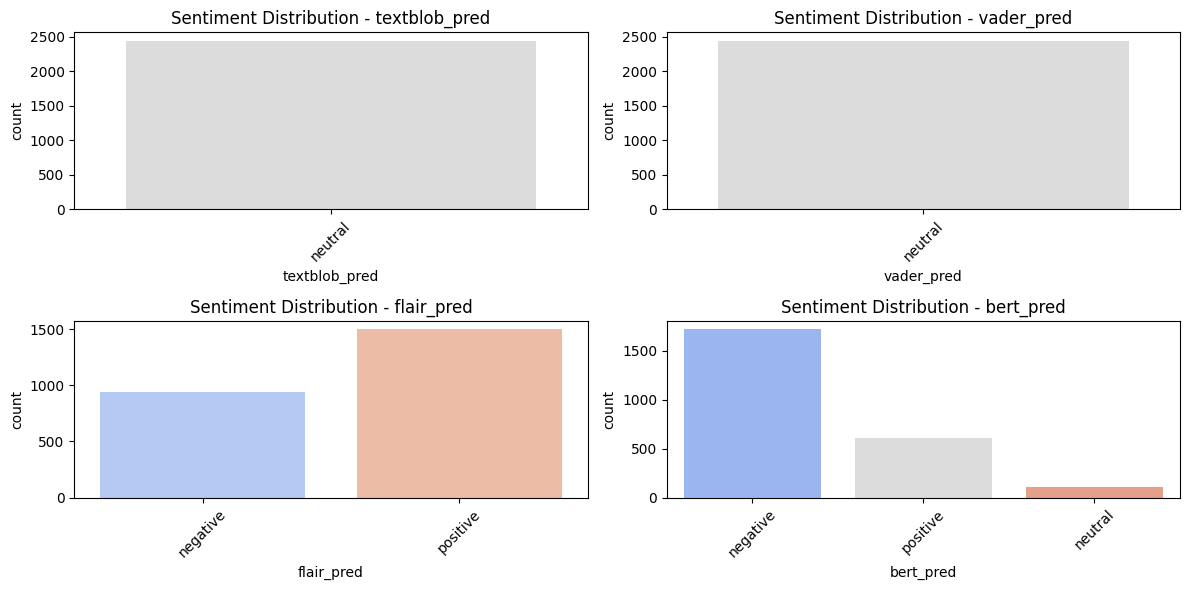

In [28]:
plt.figure(figsize=(12, 6))
for i, model in enumerate(models):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=model, data=val_df, palette='coolwarm')
    plt.title(f"Sentiment Distribution - {model}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/3352332620.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


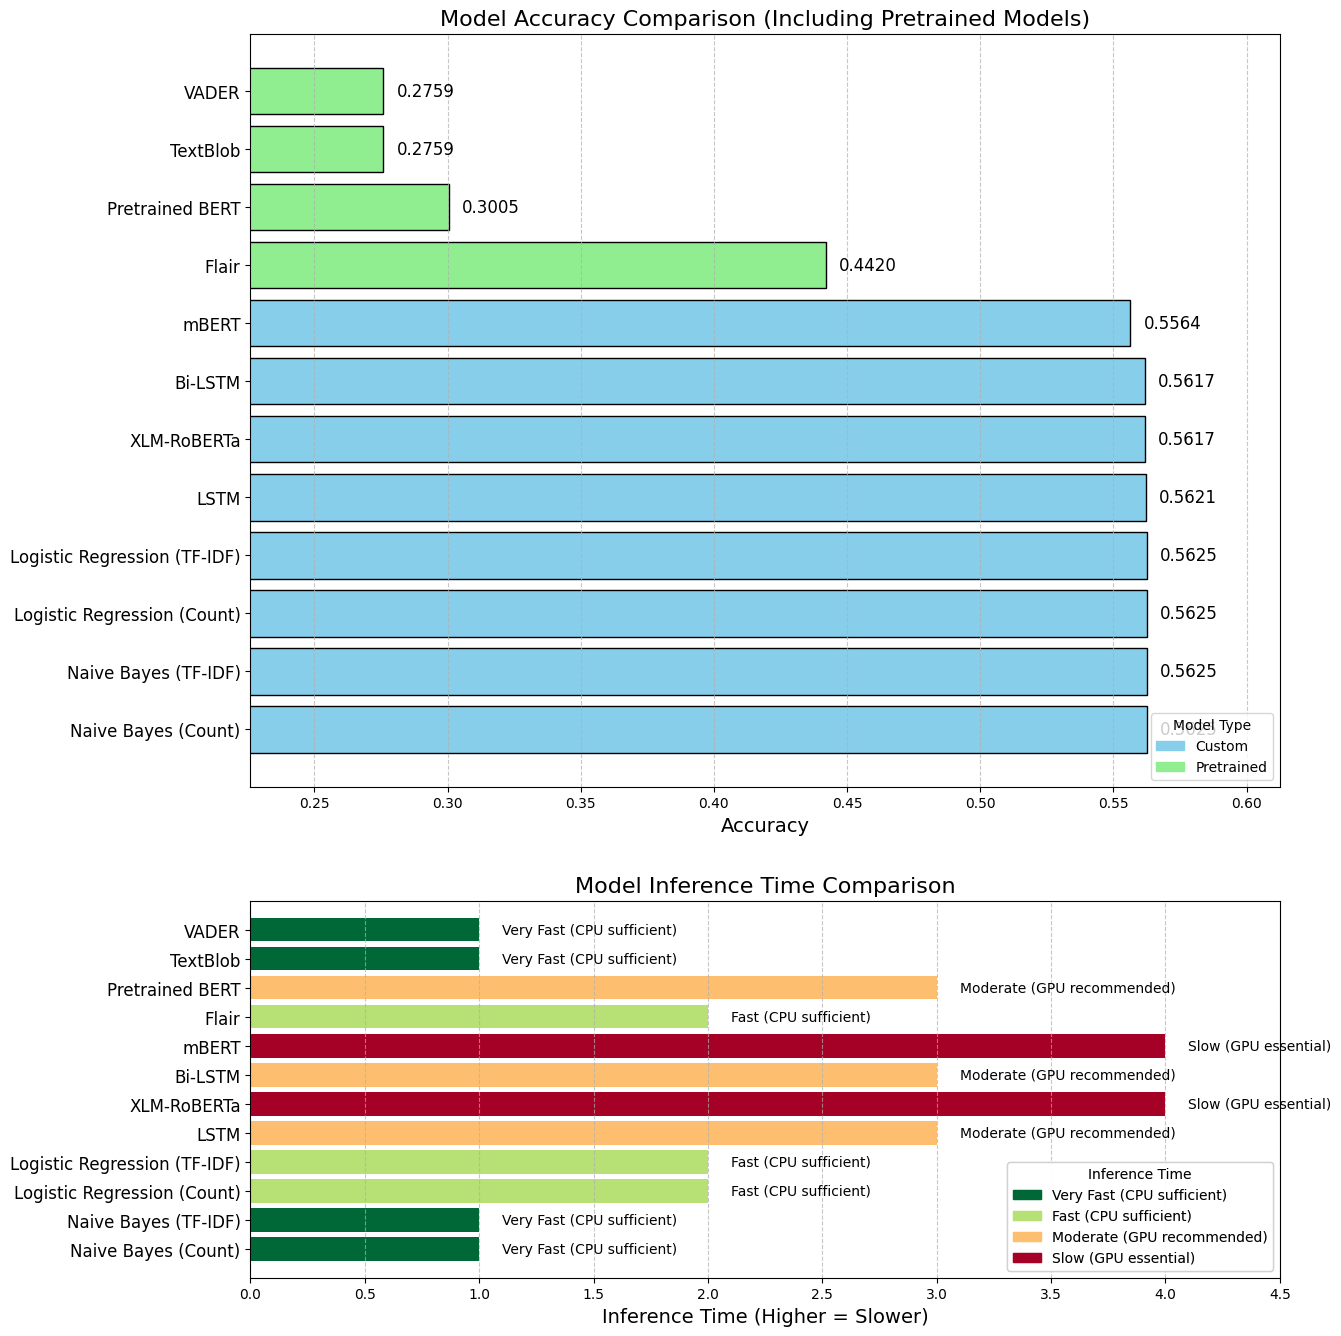


Comprehensive Model Comparison (Including Pretrained Models):
                           Model Accuracy              Inference Time  \
0   Logistic Regression (TF-IDF)   0.5625       Fast (CPU sufficient)   
1    Logistic Regression (Count)   0.5625       Fast (CPU sufficient)   
2           Naive Bayes (TF-IDF)   0.5625  Very Fast (CPU sufficient)   
3            Naive Bayes (Count)   0.5625  Very Fast (CPU sufficient)   
4                           LSTM   0.5621  Moderate (GPU recommended)   
5                        Bi-LSTM   0.5617  Moderate (GPU recommended)   
6                    XLM-RoBERTa   0.5617        Slow (GPU essential)   
7                          mBERT   0.5564        Slow (GPU essential)   
8                          Flair   0.4420       Fast (CPU sufficient)   
9                Pretrained BERT   0.3005  Moderate (GPU recommended)   
10                      TextBlob   0.2759  Very Fast (CPU sufficient)   
11                         VADER   0.2759  Very Fast (CPU suf

In [29]:
# Create a comprehensive visualization that includes all models including pretrained ones

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# First, let's calculate accuracies for the pretrained models
textblob_accuracy = accuracy_score(val_df['sa'], val_df['textblob_pred'])
vader_accuracy = accuracy_score(val_df['sa'], val_df['vader_pred'])
flair_accuracy = accuracy_score(val_df['sa'], val_df['flair_pred'])
bert_pretrained_accuracy = accuracy_score(val_df['sa'], val_df['bert_pred'])

# Combine all model performances
all_models = {
    # Original ML/DL models
    'Logistic Regression (TF-IDF)': {
        'accuracy': accuracy_score(y_val, y_val_pred_lr_tfidf),
        'inference_time': 'Fast (CPU sufficient)'
    },
    'Logistic Regression (Count)': {
        'accuracy': accuracy_score(y_val, y_val_pred_lr_count),
        'inference_time': 'Fast (CPU sufficient)'
    },
    'Naive Bayes (TF-IDF)': {
        'accuracy': accuracy_score(y_val, y_val_pred_nb_tfidf),
        'inference_time': 'Very Fast (CPU sufficient)'
    },
    'Naive Bayes (Count)': {
        'accuracy': accuracy_score(y_val, y_val_pred_nb_count),
        'inference_time': 'Very Fast (CPU sufficient)'
    },
    'LSTM': {
        'accuracy': accuracy_score(y_val_true, y_val_pred_lstm),
        'inference_time': 'Moderate (GPU recommended)'
    },
    'Bi-LSTM': {
        'accuracy': accuracy_score(y_val_true, y_val_pred_bilstm),
        'inference_time': 'Moderate (GPU recommended)'
    },
    'mBERT': {
        'accuracy': accuracy_score(y_val_true_mbert, y_val_pred_mbert),
        'inference_time': 'Slow (GPU essential)'
    },
    'XLM-RoBERTa': {
        'accuracy': accuracy_score(y_val_true_xlm, y_val_pred_xlm),
        'inference_time': 'Slow (GPU essential)'
    },
    
    # Pretrained models
    'TextBlob': {
        'accuracy': textblob_accuracy,
        'inference_time': 'Very Fast (CPU sufficient)'
    },
    'VADER': {
        'accuracy': vader_accuracy,
        'inference_time': 'Very Fast (CPU sufficient)'
    },
    'Flair': {
        'accuracy': flair_accuracy,
        'inference_time': 'Fast (CPU sufficient)'
    },
    'Pretrained BERT': {
        'accuracy': bert_pretrained_accuracy,
        'inference_time': 'Moderate (GPU recommended)'
    }
}

# Extract model performance data
models = list(all_models.keys())
accuracies = [all_models[model]['accuracy'] for model in models]

# Create inference time categories for visualization
inference_time_categories = {
    'Very Fast (CPU sufficient)': 1,
    'Fast (CPU sufficient)': 2,
    'Moderate (GPU recommended)': 3,
    'Slow (GPU essential)': 4
}

# Map inference times to numeric values for visualization
inference_times = [inference_time_categories[all_models[model]['inference_time']] for model in models]

# Sort models by accuracy
sorted_indices = np.argsort(accuracies)[::-1]  # Descending order
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]
sorted_inference_times = [inference_times[i] for i in sorted_indices]

# Create category colors (custom models vs pretrained)
model_categories = []
for model in sorted_models:
    if model in ['TextBlob', 'VADER', 'Flair', 'Pretrained BERT']:
        model_categories.append('Pretrained')
    else:
        model_categories.append('Custom')

# Create color mapping for model categories
category_colors = {'Custom': 'skyblue', 'Pretrained': 'lightgreen'}
bar_colors = [category_colors[cat] for cat in model_categories]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Bar chart of accuracies - use horizontal bars for better readability
y_pos = np.arange(len(sorted_models))
bars = ax1.barh(y_pos, sorted_accuracies, color=bar_colors, edgecolor='black')
ax1.set_title('Model Accuracy Comparison (Including Pretrained Models)', fontsize=16)
ax1.set_xlabel('Accuracy', fontsize=14)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_models, fontsize=12)
ax1.set_xlim([min(sorted_accuracies) - 0.05, max(sorted_accuracies) + 0.05])
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Add accuracy values next to bars
for i, bar in enumerate(bars):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f"{sorted_accuracies[i]:.4f}", va='center', fontsize=12)

# Create a custom colormap for inference times
cmap = plt.cm.get_cmap('RdYlGn_r')
norm = plt.Normalize(min(inference_times), max(inference_times))
time_colors = [cmap(norm(time)) for time in sorted_inference_times]

# Plot 2: Horizontal bar chart for inference time
inference_bars = ax2.barh(y_pos, sorted_inference_times, color=time_colors)
ax2.set_title('Model Inference Time Comparison', fontsize=16)
ax2.set_xlabel('Inference Time (Higher = Slower)', fontsize=14)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_models, fontsize=12)
ax2.set_xlim([0, max(inference_times) + 0.5])
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# Create legend for inference time
handles_time = [plt.Rectangle((0,0), 1, 1, color=cmap(norm(i))) for i in range(1, 5)]
labels_time = list(inference_time_categories.keys())
time_legend = ax2.legend(handles_time, labels_time, loc='lower right', title='Inference Time')
ax2.add_artist(time_legend)

# Create legend for model categories
handles_cat = [plt.Rectangle((0,0), 1, 1, color=color) for color in category_colors.values()]
labels_cat = list(category_colors.keys())
ax1.legend(handles_cat, labels_cat, loc='lower right', title='Model Type')

# Add inference time description to each bar
for i, bar in enumerate(inference_bars):
    ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             list(inference_time_categories.keys())[sorted_inference_times[i]-1], 
             va='center', fontsize=10)

plt.tight_layout(pad=3.0)  # Add more padding between subplots
plt.show()

# Create a comprehensive comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Inference Time': [all_models[model]['inference_time'] for model in models],
    'Model Type': ['Pretrained' if model in ['TextBlob', 'VADER', 'Flair', 'Pretrained BERT'] else 'Custom' for model in models]
})

# Format accuracy values
comparison_df['Accuracy'] = comparison_df['Accuracy'].apply(lambda x: f"{x:.4f}")

# Sort by accuracy (descending)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Print the comprehensive comparison table
print("\nComprehensive Model Comparison (Including Pretrained Models):")
print(comparison_df)